Image class: 3


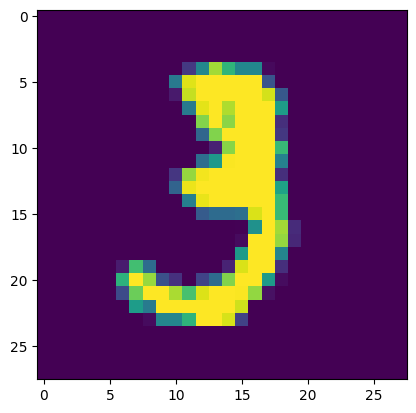

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAEConditioned
from schedulers import DDPM
from schedulers import DDIMSampler




mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


mnist_dataset.data[10]

plt.imshow(mnist_dataset.data[10])
print(f"Image class: {mnist_dataset.targets[10]}")

In [ ]:
# Create DataLoader
batch_size = 128
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer and loss function
unet = UNetTimed() #UNetTimedWithVAEConditioned(vae=None,use_condition=False)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
total_params = sum(p.numel() for p in unet.parameters())
print(f"Total parameters: {total_params:,}")
# DDPM instance
ddpm = DDPM(0.001, 0.2, 1000)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Generate random noise
        noise = torch.randn_like(images).to(device)
        
        # Generate random timesteps
        batch_size = images.shape[0]
        timesteps = torch.randint(0, ddpm.max_timestep, (batch_size,), device=device)
        
        # Add noise to images according to timesteps
        noised_images = ddpm.add_noise(images, timesteps, noise)
        
        # Predict noise
        predicted_noise = unet(noised_images, timesteps)
        
        # Calculate loss
        loss = mse_loss(predicted_noise, noise)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')
    
    # Optional: Save checkpoint
    # if (epoch + 1) % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': unet.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': avg_loss,
    #     }, f'ddpm_checkpoint_epoch_{epoch+1}.pt')

Total parameters: 9,544,437
Epoch 0 | Batch 0 | Loss: 1.9611
Epoch 0 | Batch 100 | Loss: 0.1089
Epoch 0 | Batch 200 | Loss: 0.0771
Epoch 0 | Batch 300 | Loss: 0.0596
Epoch 0 | Batch 400 | Loss: 0.0424
Epoch 0 | Average Loss: 0.1032
Epoch 1 | Batch 0 | Loss: 0.0395
Epoch 1 | Batch 100 | Loss: 0.0373
Epoch 1 | Batch 200 | Loss: 0.0346
Epoch 1 | Batch 300 | Loss: 0.0323
Epoch 1 | Batch 400 | Loss: 0.0369
Epoch 1 | Average Loss: 0.0320
Epoch 2 | Batch 0 | Loss: 0.0323
Epoch 2 | Batch 100 | Loss: 0.0261
Epoch 2 | Batch 200 | Loss: 0.0277
Epoch 2 | Batch 300 | Loss: 0.0195
Epoch 2 | Batch 400 | Loss: 0.0262
Epoch 2 | Average Loss: 0.0262
Epoch 3 | Batch 0 | Loss: 0.0228
Epoch 3 | Batch 100 | Loss: 0.0292
Epoch 3 | Batch 200 | Loss: 0.0252
Epoch 3 | Batch 300 | Loss: 0.0247
Epoch 3 | Batch 400 | Loss: 0.0200
Epoch 3 | Average Loss: 0.0235
Epoch 4 | Batch 0 | Loss: 0.0211
Epoch 4 | Batch 100 | Loss: 0.0181
Epoch 4 | Batch 200 | Loss: 0.0235
Epoch 4 | Batch 300 | Loss: 0.0240
Epoch 4 | Batch 40

KeyboardInterrupt: 

In [ ]:
# unet.load_state_dict(torch.load("/home/nazara/Data/UCU/CV_GENAI_2_3/ddpm_checkpoint_epoch_10.pt")['model_state_dict'])
# unet.eval()

/tmp/ipykernel_66097/3270342712.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load("/home/nazara/Data/UCU/CV_GENAI_2_3/ddpm_checkpoint_epoch

UNetTimed(
  (time_embedding): TimeEmbedding(
    (projection): Sequential(
      (0): Linear(in_features=100, out_features=400, bias=True)
      (1): SiLU()
      (2): Linear(in_features=400, out_features=100, bias=True)
    )
  )
  (doubleconv1): DoubleConvLayer(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (downsample1): DownSampleLayer(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
    (norm2): GroupNorm(8, 128, eps=1e-05, a

In [3]:
import numpy as np
class DDIMSampler:
    def __init__(self,beta_start, beta_end, timesteps=1000):
        # self.num_timesteps = num_timesteps
        # Create beta schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        # Calculate alphas
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.max_timestep = timesteps
        self.eps = 1e-8

        
    def sample(self, model, n_samples, img_size, device, steps=100, condition = None):
        # Start from pure noise
        x = torch.randn(n_samples, *img_size).to(device)
        if condition is None:
            condition = torch.zeros(n_samples).to(device).to(torch.long) -1 # -1 is for null condition
        else: 
            if condition.device != device:
                condition = condition.to(device)
            assert condition.shape == (n_samples,) and condition.dtype == torch.long, "Condition must be a tensor of shape (n_samples,) and dtype torch.long"
        # Create sampling timestep sequence
        timesteps = np.linspace(self.max_timestep - 1, 0, steps).astype(np.int64)
        
        for i in range(len(timesteps) - 1):
            t = timesteps[i]
            t_prev = timesteps[i + 1]
            
            # Get current alphas
            at = self.alphas_cumprod[t] + self.eps
            at_prev = self.alphas_cumprod[t_prev] + self.eps
            
            # Model prediction of noise
            with torch.no_grad():
                noise_pred = model(x, torch.tensor([t]).to(device))
            
            # Predict x0 (clean image)
            pred_x0 = (x - torch.sqrt(1 - at) * noise_pred) / torch.sqrt(at)
            
            # DDIM deterministic formula
            x = torch.sqrt(at_prev) * pred_x0 + \
                torch.sqrt(1 - at_prev) * noise_pred
            
        return x

In [4]:
import numpy as np
import torch

class DDPMSampler:
    def __init__(self, beta_start, beta_end, timesteps=1000):
        # Create beta schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        # Calculate alphas
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.max_timestep = timesteps
        self.eps = 1e-8

    def sample(self, model, n_samples, img_size, device, steps=100, condition=None):
        # Start from pure noise
        x = torch.randn(n_samples, *img_size).to(device)
        if condition is None:
            condition = torch.zeros(n_samples).to(device).long() - 1  # Null condition
        else:
            if condition.device != device:
                condition = condition.to(device)
            assert condition.shape == (n_samples,) and condition.dtype == torch.long, \
                "Condition must be a tensor of shape (n_samples,) and dtype torch.long"
        
        # Create sampling timestep sequence
        timesteps = np.linspace(self.max_timestep - 1, 0, steps).astype(np.int64)
        
        for i in range(len(timesteps) - 1):
            t = timesteps[i]
            t_prev = timesteps[i + 1]
            
            # Get current alpha and beta values
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alphas_cumprod[t]
            beta_t = 1 - alpha_t
            
            # Predict noise using the model (with condition)
            with torch.no_grad():
                noise_pred = model(x, torch.tensor([t]).to(device))
            
            # Calculate the mean of the previous step
            x_prev_mean = (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred) / torch.sqrt(alpha_t)
            
            # Add stochastic noise
            noise = torch.randn_like(x)
            x_prev = x_prev_mean + torch.sqrt(beta_t) * noise
            
            x = x_prev  # Update x for next iteration
        
        return x

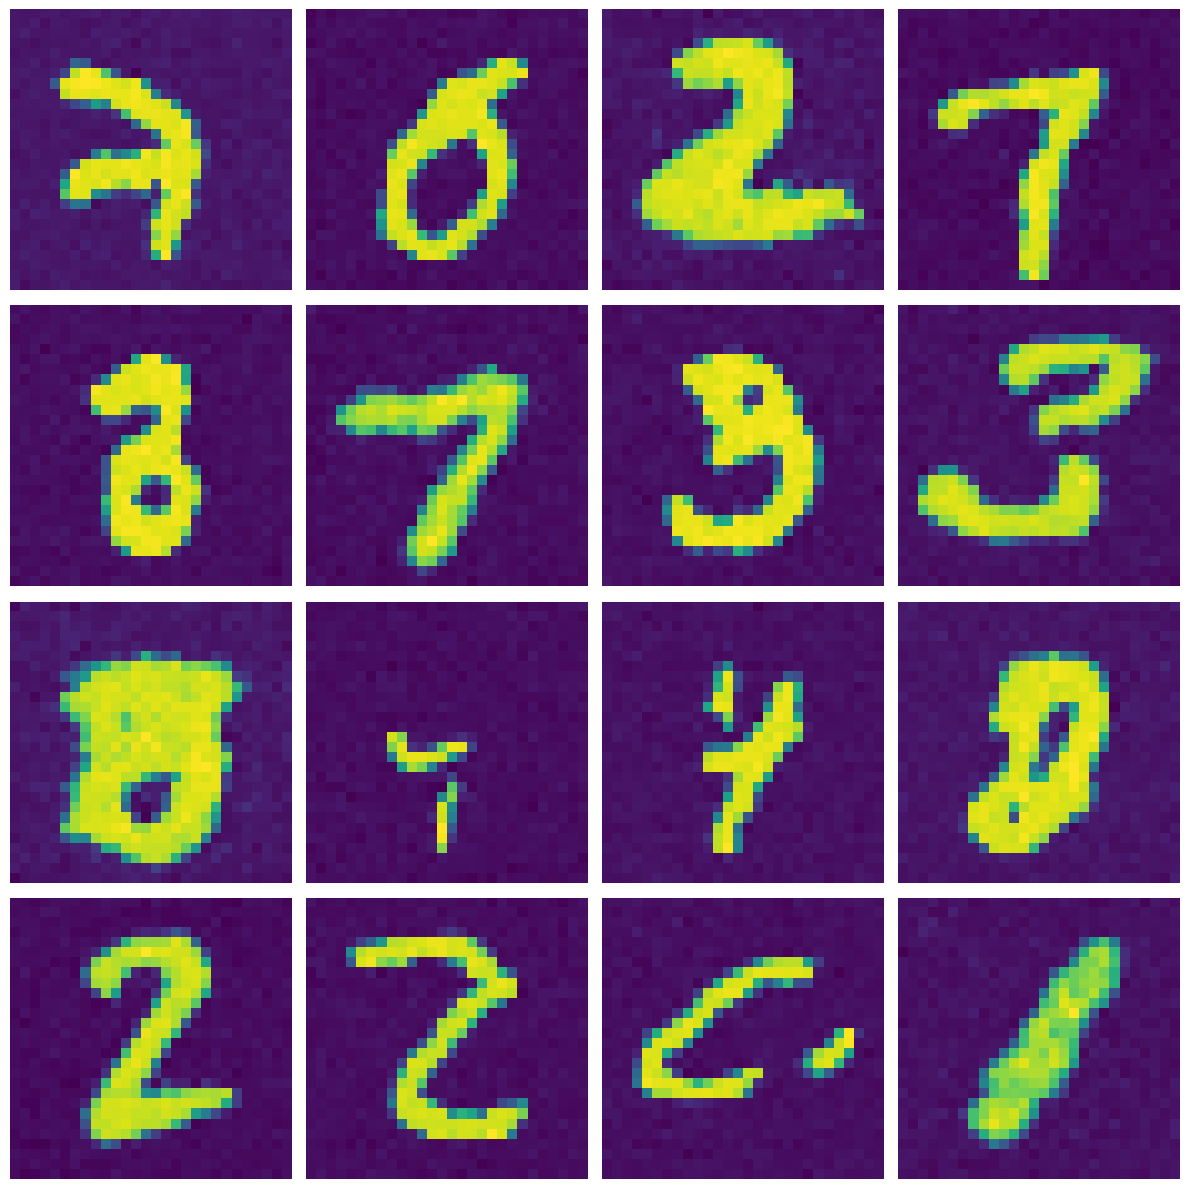

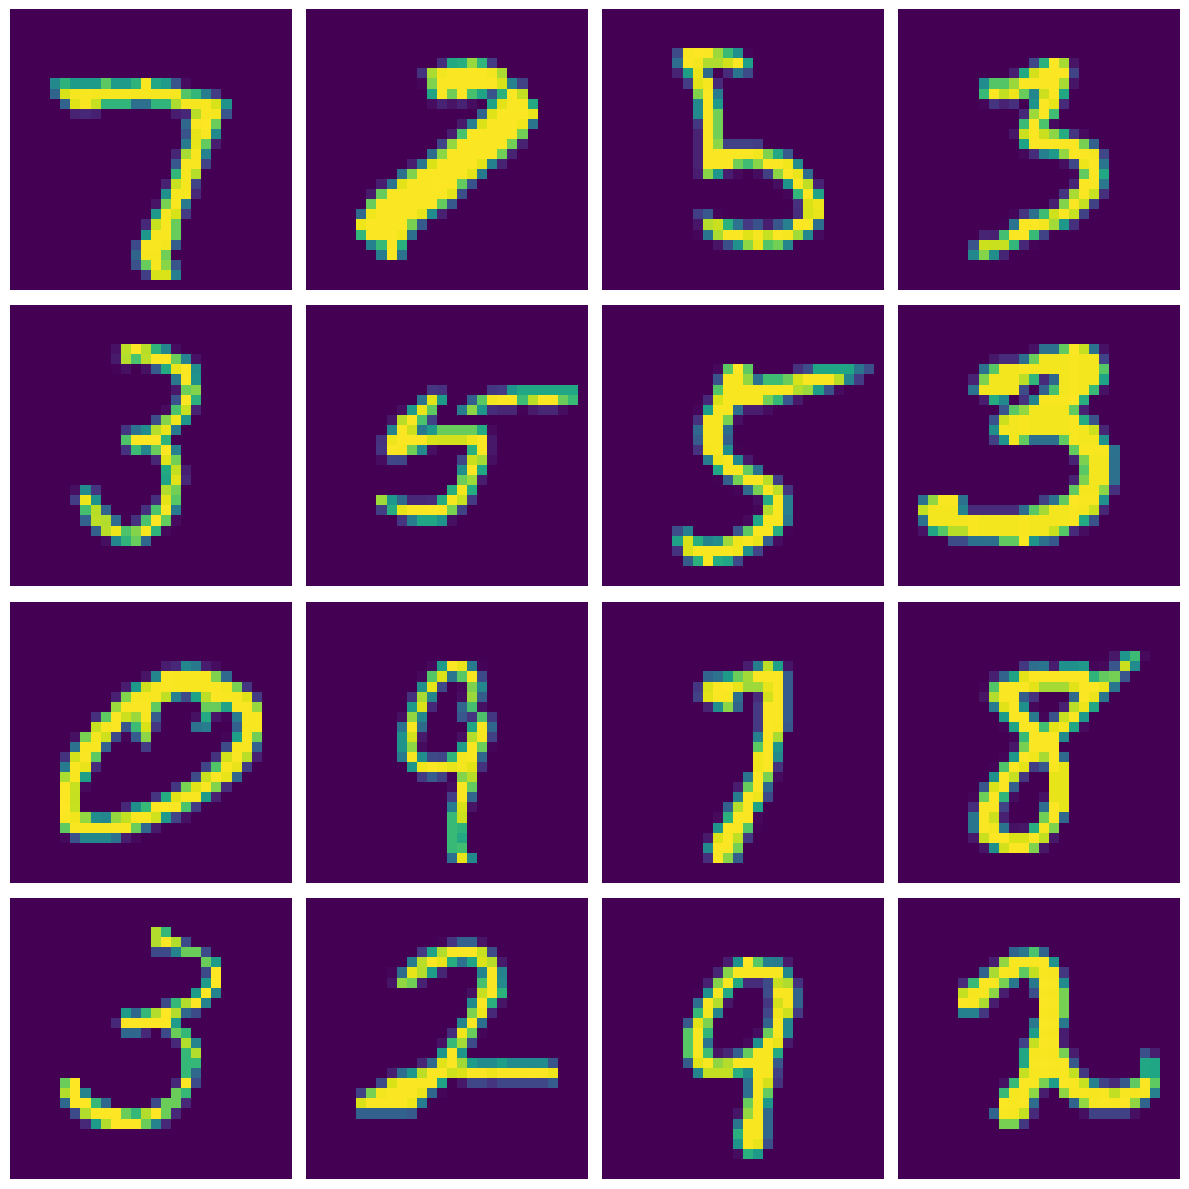

In [17]:
sampler = DDPMSampler(0.001, 0.2, 1000)
sample_images = sampler.sample(
    model=unet.eval(),
    n_samples=16,
    img_size=(1, 28, 28),  # For MNIST
    device=device,
    steps=1000 # Can use fewer steps than training
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = sample_images[i, 0].cpu().numpy()
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()




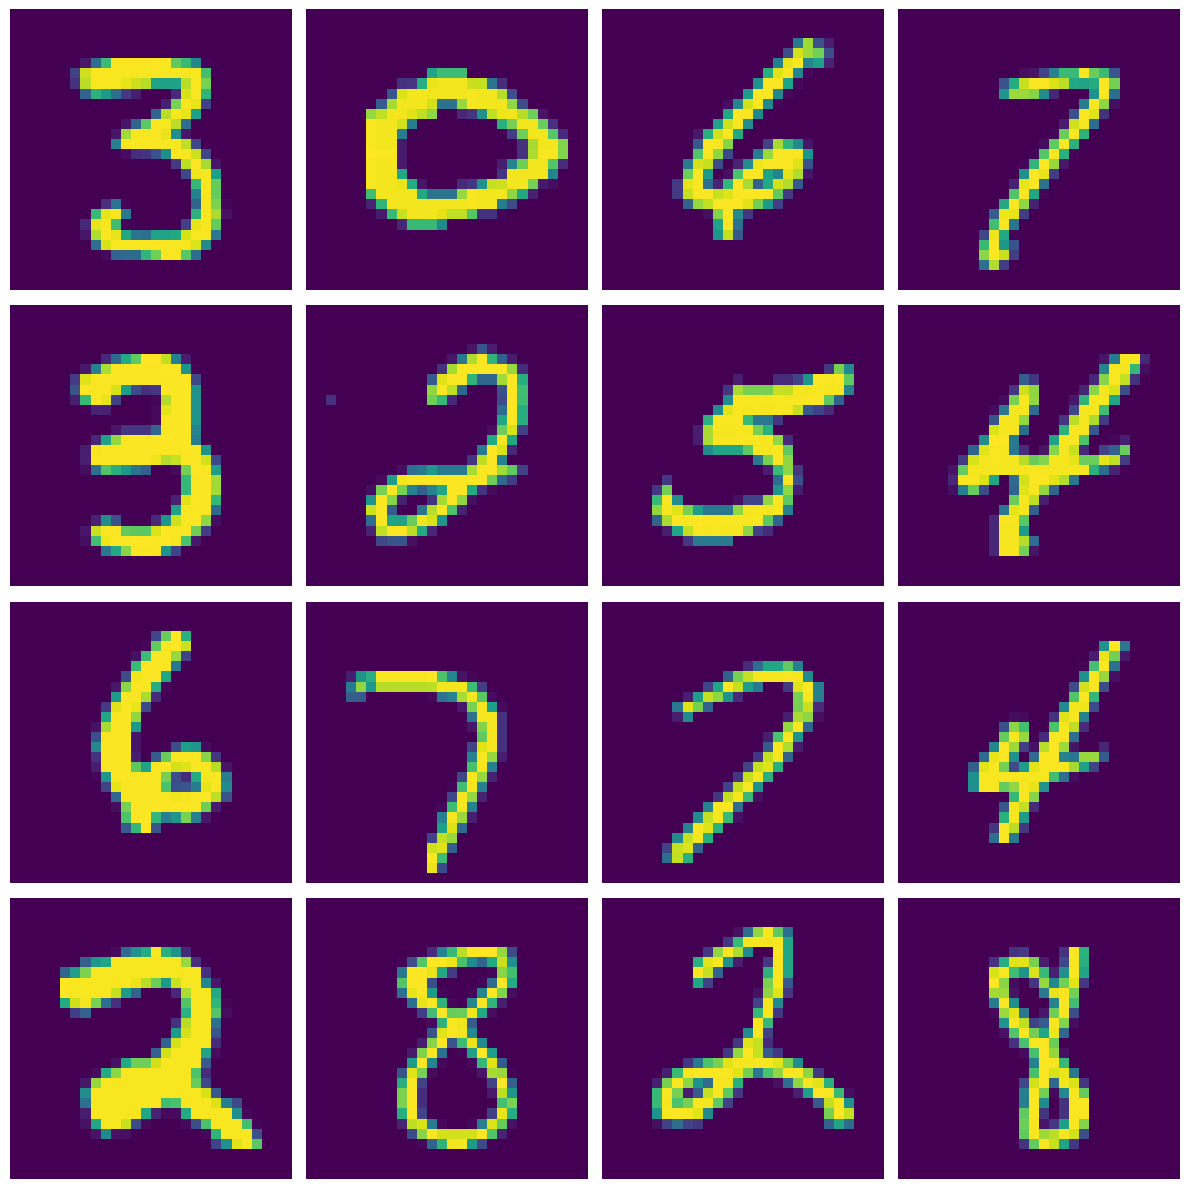

In [30]:

# Get 16 random indices
random_indices = torch.randint(0, len(mnist_dataset), (16,))

# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each random sample
for i, idx in enumerate(random_indices):
    plt.subplot(4, 4, i + 1)
    img = mnist_dataset.data[idx].numpy()
    plt.imshow(img)
    # plt.title(f"Class: {mnist_dataset.targets[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


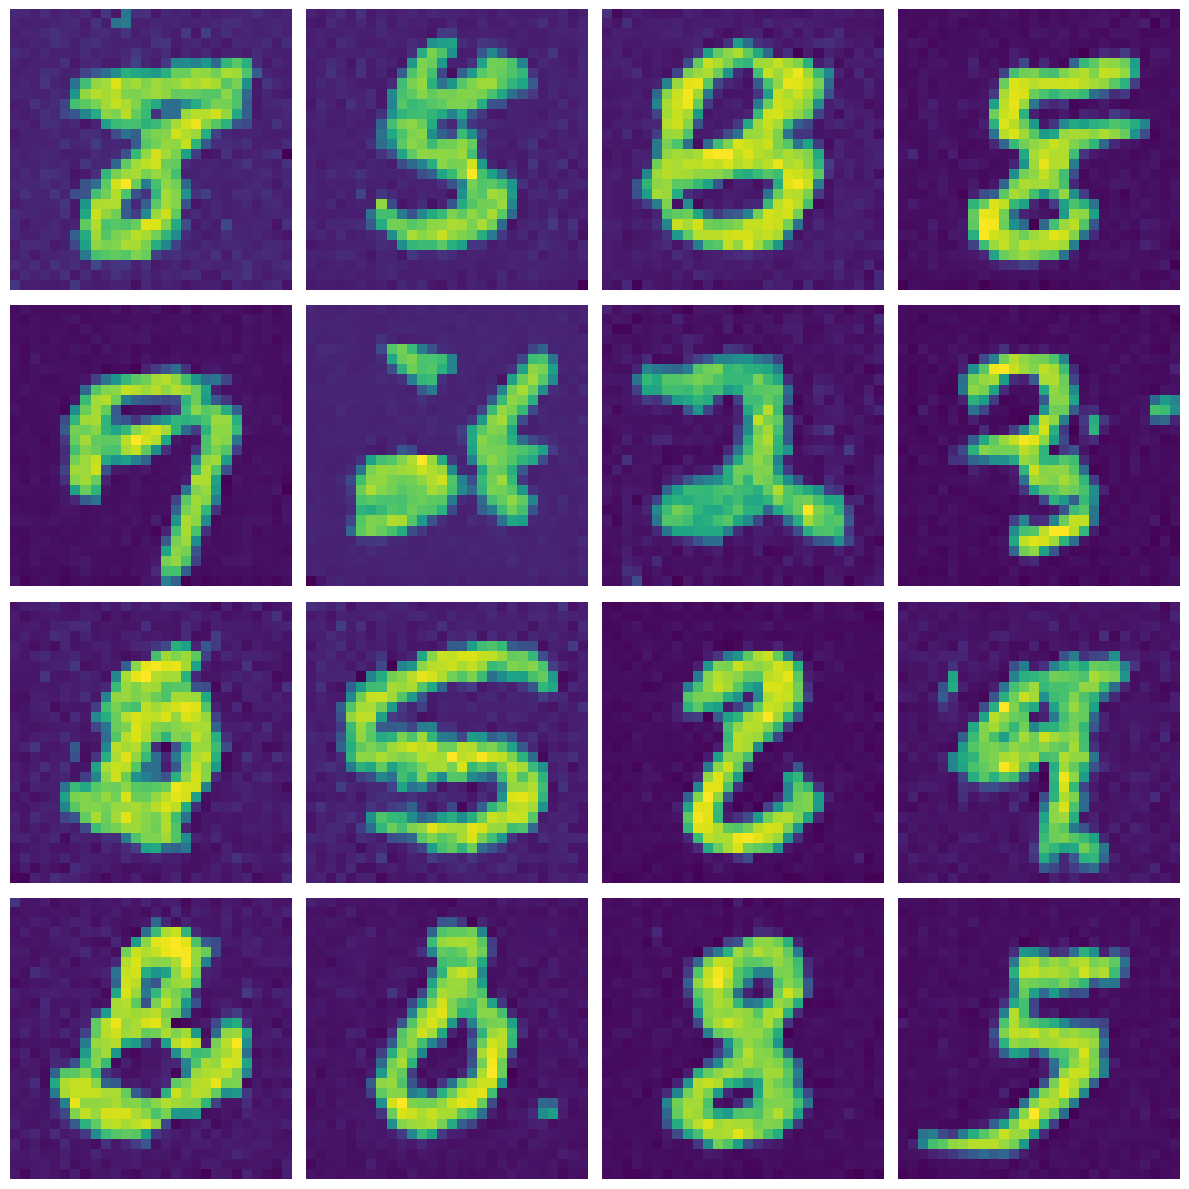

In [13]:
sampler = DDIMSampler(0.001, 0.2, 1000)
sample_images = sampler.sample(
    model=unet.eval(),
    n_samples=16,
    img_size=(1, 28, 28),  # For MNIST
    device=device,
    steps=1000 # Can use fewer steps than training
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = sample_images[i, 0].cpu().numpy()
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

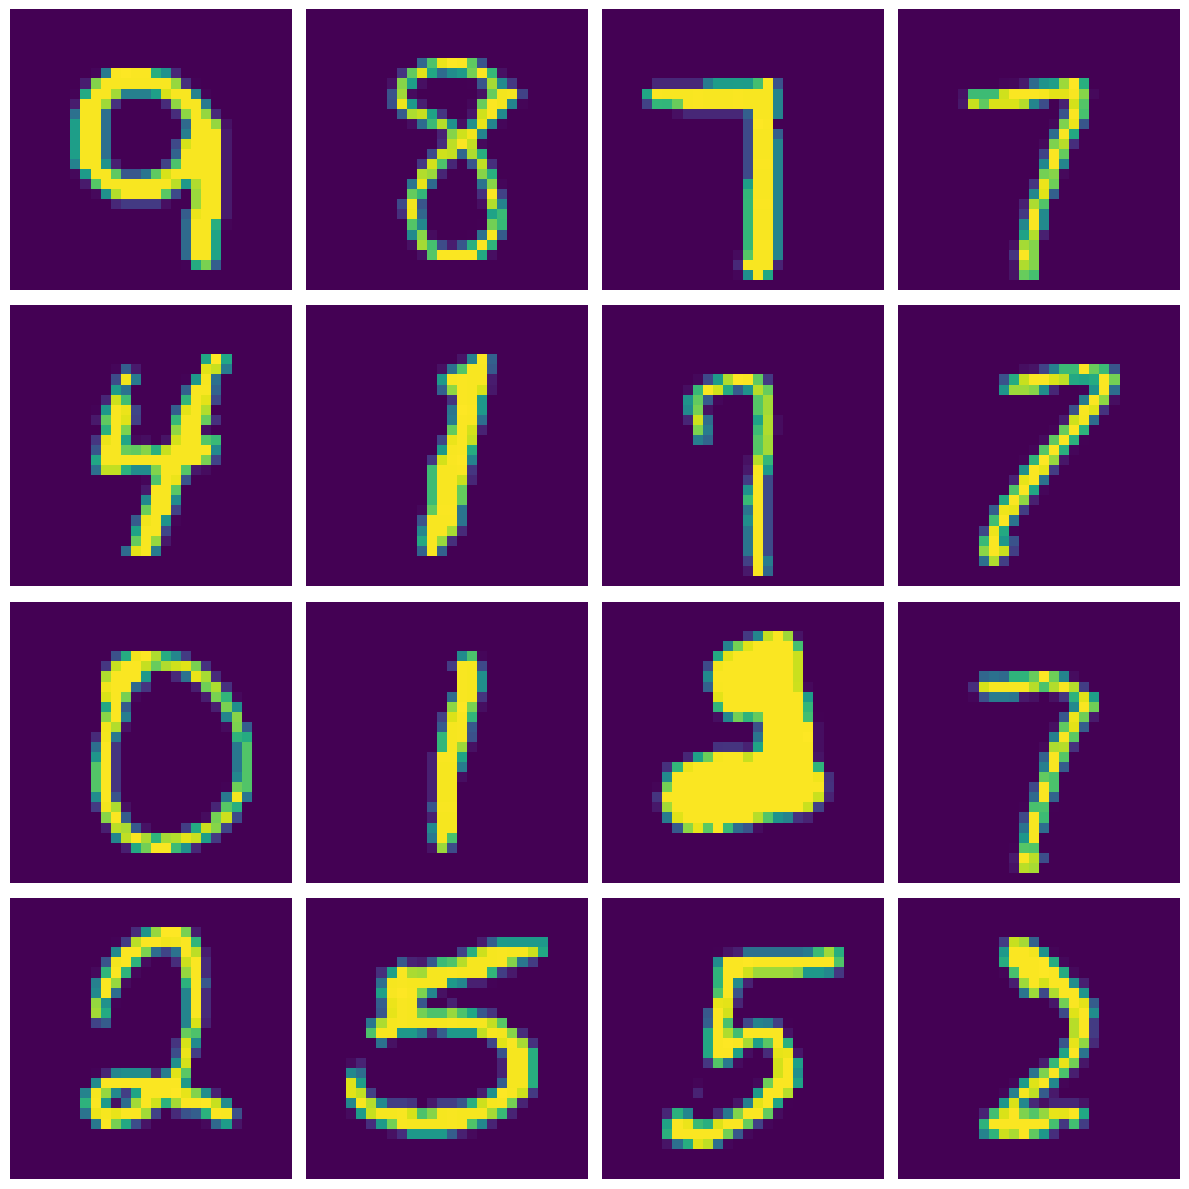

In [15]:

# Get 16 random indices
random_indices = torch.randint(0, len(mnist_dataset), (16,))

# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each random sample
for i, idx in enumerate(random_indices):
    plt.subplot(4, 4, i + 1)
    img = mnist_dataset.data[idx].numpy()
    plt.imshow(img)
    # plt.title(f"Class: {mnist_dataset.targets[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
